# Emotions Detection with Transfer Learning

## dependencies

In [1]:
import os
import random
import imghdr
from PIL import Image
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

/tmp/ipython-input-3600390012.py:3: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


## datasets; FER2013

In [2]:
# kaggle api configuration
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# downloading the fer2013 dataset
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 1.81GB/s]


In [4]:
!ls

fer2013.zip  kaggle.json  sample_data


In [ ]:
# unzipping the dataset
!unzip /content/fer2013.zip -d /content/

In [6]:
!ls

fer2013.zip  kaggle.json  sample_data  test  train


## model data directories

In [7]:
# project name
project_name = "Emotion_Detection_FER2013"

# models list
model_names = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augmentation',
    'VGG16_Transfer_Learning',
    'ResNet50_Transfer_Learning'
]

# base directory
base_dir = "/content/"

In [8]:
# creating project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

In [9]:
# creating model's sub-directories
for model_name in model_names:
  model_dir = os.path.join(project_dir, model_name)
  os.makedirs(model_dir, exist_ok=True)

## data cleaning

In [10]:
# possible image extensions
exts = ["jpg", "jpeg", "png"]
data_dir = "/content/train"

In [11]:
for root, dirs, files in os.walk(data_dir):
  for file in files:
    file_path = os.path.join(root, file)

    try:
      # file type of the currrent type
      file_type = imghdr.what(file_path)
      if file_type not in exts:
        print(f"Image not in extensions list {file_path}")
        os.remove(file_path)
      else:
        img = cv2.imread(file_path)

    except Exception as e:
      print(f"issue with file {file_path}. error: {e}")

## exploratory data analysis

In [12]:
# file counter function
def count_subdirs_files(directory, set_name):
  counts = {}
  for item in os.listdir(directory):
    item_path = os.path.join(directory, item)
    if os.path.isdir(item_path):
      counts[item] = len(os.listdir(item_path))

  data = pd.DataFrame(counts, index=[set_name])
  return data

In [13]:
# train test directory
train_dir = "/content/train"
test_dir = "/content/test"

In [14]:
# train count
train_count = count_subdirs_files(train_dir, "train")
print(train_count)

       fear  disgust  happy  neutral  surprise  angry   sad
train  4097      436   7215     4965      3171   3995  4830


In [15]:
# test count
test_count = count_subdirs_files(test_dir, "test")
print(test_count)

      fear  disgust  happy  neutral  surprise  angry   sad
test  1024      111   1774     1233       831    958  1247


<Axes: >

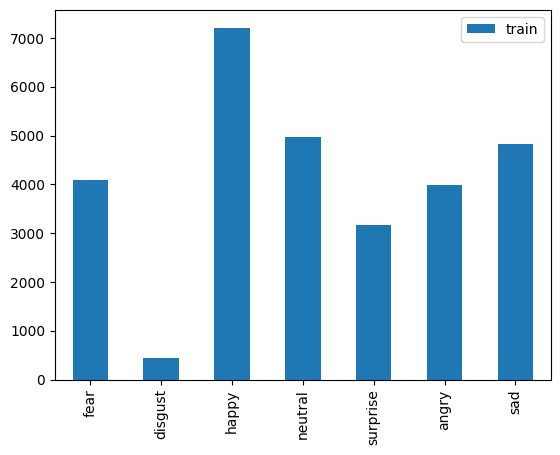

In [16]:
# simple train barplot
train_count.transpose().plot(kind="bar")

<Axes: >

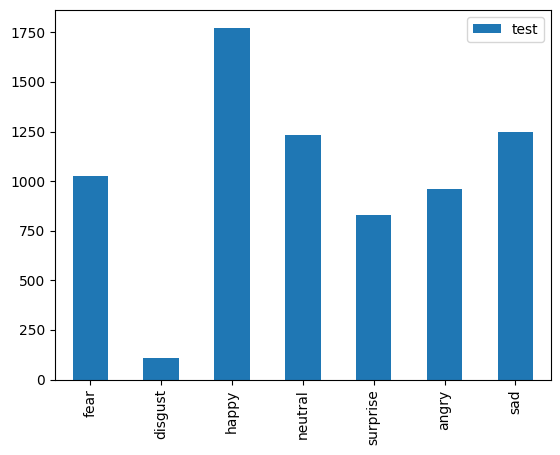

In [17]:
test_count.transpose().plot(kind="bar")

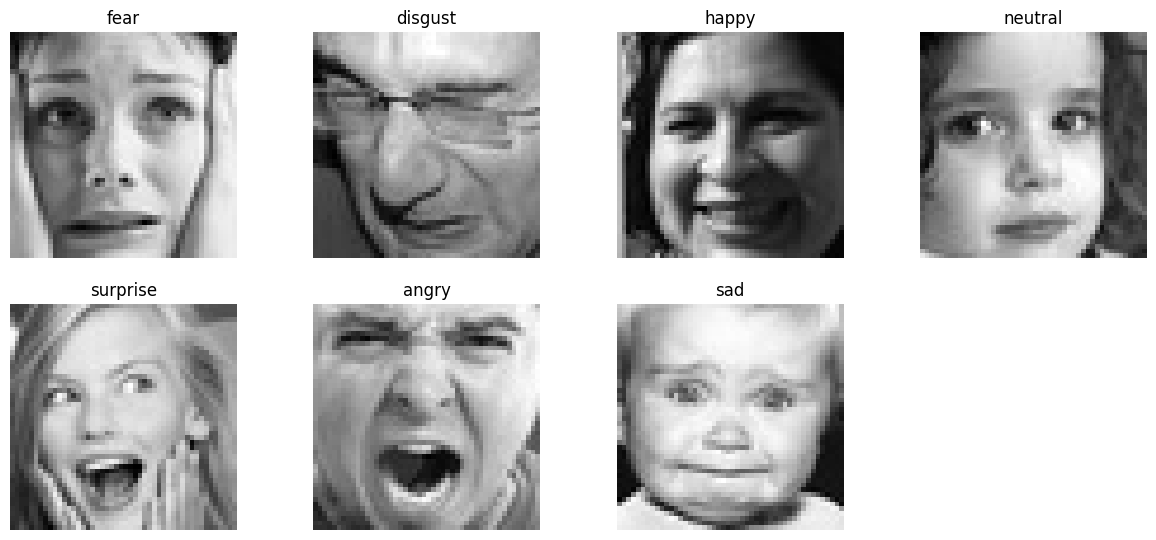

In [25]:
# plotting one image from each emotion
emotions = os.listdir(train_dir)
plt.figure(figsize=(15, 10))

for idx, emotion in enumerate(emotions, 1):
  folder = os.path.join(train_dir, emotion)
  img_path = os.path.join(folder, os.listdir(folder)[42])
  img = plt.imread(img_path)
  plt.subplot(3, 4, idx)
  plt.imshow(img, cmap="gray")
  plt.title(emotion)
  plt.axis("off")

## plotting random images from the given directory

In [19]:
def plot_from_dir(dir_path, cls_name, num_imgs=9):
  img_names = os.listdir(dir_path)
  if len(img_names) < num_imgs:
    print(f"only found {len(img_names)} images in {dir_path}. displaying them all")
    num_imgs = img_names

  # selecting random images
  imgs_select = random.sample(img_names, num_imgs)

  # plotting the images
  fig, ax = plt.subplots(3, 3, figsize=(6, 6))
  ax = ax.ravel()

  for idx, img, in enumerate(imgs_select):
    img_path = os.path.join(dir_path, img)
    image = Image.open(img_path)
    ax[idx].imshow(image)
    ax[idx].set_title(f"image: {cls_name}")
    ax[idx].axis("off")

  plt.tight_layout()
  plt.show()

In [20]:
# sample emotions paths
angry_path = "/content/train/angry"
fear_path = "/content/train/fear"
neutral_path = "/content/train/neutral"
sad_path = "/content/train/sad"

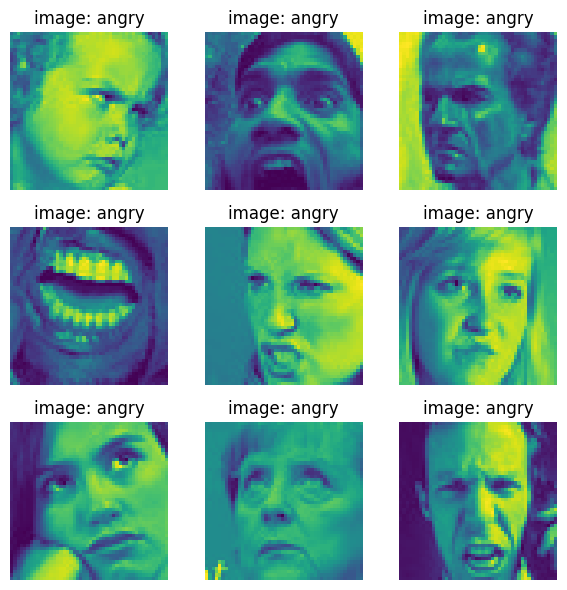

In [21]:
# plotting angry
plot_from_dir(angry_path, cls_name="angry")

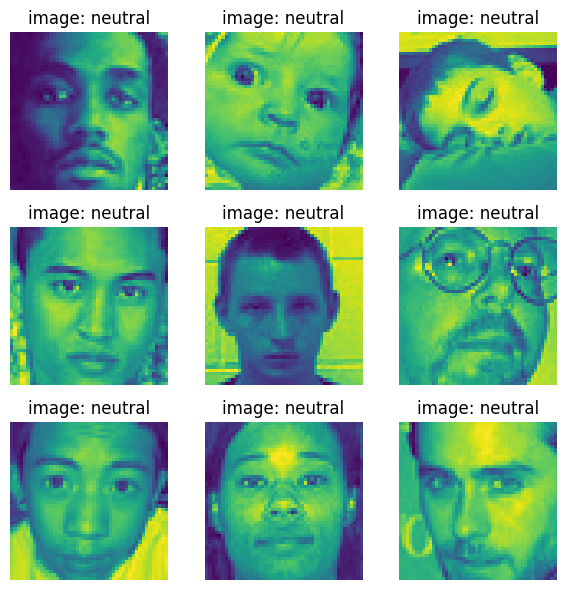

In [22]:
# plotting neutral
plot_from_dir(neutral_path, cls_name="neutral")

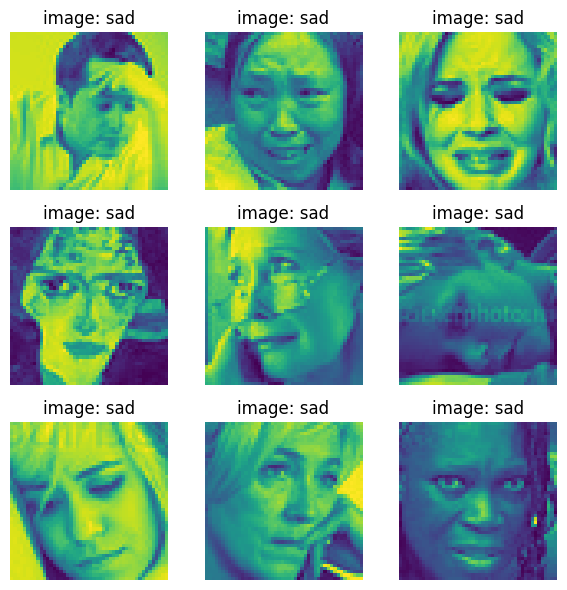

In [23]:
# plotting sad
plot_from_dir(sad_path, cls_name="sad")

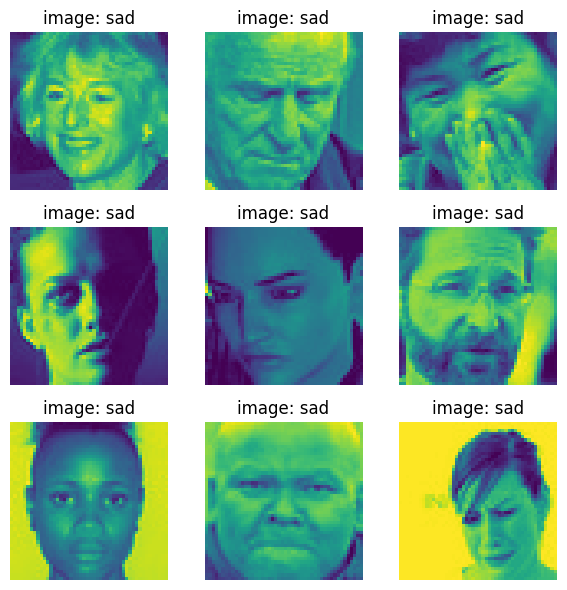

In [24]:
# plotting sad
plot_from_dir(sad_path, cls_name="sad")